In [1]:
# For connecting Colab and Google Drive
from google.colab import drive
drive.mount('/content/g_drive')
%cd g_drive/My\ Drive/MSA\ 2020\ Data\ Science

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/g_drive
/content/g_drive/My Drive/MSA 2020 Data Science


In [98]:
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
# !curl https://raw.githubusercontent.com/NZMSA/2020-Phase-1/master/Machine%20Learning%20and%20Data%20Science/Dataset%20for%20Assignment.csv -O
# !curl https://www.otago.ac.nz/wellington/otago730395.xlsx -O

## 1. Data Preparation

In [ ]:
df = pd.read_csv('Dataset for Assignment.csv')
df

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,4,1.0,"19 Landscape Road, Auckland",1368 m²,670000,-36.899255,174.761165,7005464,54,18,15,24,21,27,Mount Eden
1047,6,1.0,"56 Galway Street, Auckland",607 m²,1200000,-36.844933,174.770001,7005497,15,27,24,15,18,30,Auckland Central
1048,5,3.0,"28A Hayr Road, Auckland",453 m²,1250000,-36.912242,174.756726,7007758,36,30,45,21,24,21,Three Kings
1049,5,2.0,"27 Market Road, Auckland",1854 m²,5300000,-36.879665,174.787668,7005745,48,18,12,15,36,45,Remuera


In [ ]:
layer_id = '104612'

def get_population(longitude, latitude):
    url = 'https://koordinates.com/services/query/v1/vector.json'
    params = {
        'key': '85f3f86fccbf4f6fa8da33944ed76ef5',
        'layer': layer_id,
        'x': longitude,
        'y': latitude
    }
    response = requests.get(url, params=params)
    # if response.status_code != 200:
    #     return response.status_code
    return response.json()['vectorQuery']['layers'][layer_id]['features'][0]['properties']['C18_CURPop']

In [ ]:
df2 = pd.read_excel('otago730395.xlsx')
cols = [3, 4, 5]
df2.drop(df2.columns[cols], axis=1, inplace=True)
df = df.merge(df2, left_on='SA1', right_on='SA12018_code')

In [ ]:
df['population'] = df.apply(lambda row: get_population(row['Longitude'], row['Latitude']), axis = 1)

In [ ]:
df.to_csv('Properties.csv', index=False)

## 2. Data Analysis

In [3]:
properties = pd.read_csv('Properties.csv')
properties.head()

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,SA12018_code,NZDep2018,NZDep2018_Score,population
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,7009770,6.0,997.0,174
1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,7009991,1.0,881.0,129
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,7009991,1.0,881.0,129
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,7007871,2.0,908.0,120
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,7008902,9.0,1091.0,231


In [4]:
properties.shape

(1051, 19)

In [5]:
# check if there are any null values in dataset
properties.isnull().values.any()

True

In [6]:
# find rows with missing values
properties[properties.isnull().any(axis=1)]

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,SA12018_code,NZDep2018,NZDep2018_Score,population
309,4,NaN,"14 Hea Road Hobsonville, Auckland",214,1250000,-36.798371,174.647430,7002267,60,66,60,24,24,18,Hobsonville,7002267,2.0,911.0,252
311,4,NaN,"16 Hea Road Hobsonville, Auckland",245,1100000,-36.798371,174.647430,7002267,60,66,60,24,24,18,Hobsonville,7002267,2.0,911.0,252
568,1,1.0,"14 Te Rangitawhiri Road Great Barrier Island, ...",2141,740000,-36.197282,175.416921,7001131,27,6,6,18,39,60,NaN,7001131,9.0,1122.0,156


In [7]:
# only 3 rows have missing values, we can drop them
properties = properties.dropna()
properties.shape

(1048, 19)

In [8]:
properties.dtypes
# Land area is objects, i.e., strings, when it should be numbers.

Bedrooms             int64
Bathrooms          float64
Address             object
Land area           object
CV                   int64
Latitude           float64
Longitude          float64
SA1                  int64
0-19 years           int64
20-29 years          int64
30-39 years          int64
40-49 years          int64
50-59 years          int64
60+ years            int64
Suburbs             object
SA12018_code         int64
NZDep2018          float64
NZDep2018_Score    float64
population           int64
dtype: object

In [ ]:
# see all the unique values in that column
# properties['Land area'].unique()
# We find Land area is strings because some rows have m² suffix.

In [9]:
properties['Land area'] = properties['Land area'].str.extract('(\d+)').astype(float)    # extract numbers from strings
# properties['Land area'] = properties['Land area'].apply(lambda land_area: land_area.replace(' m²', ''))
# properties['Land area'] = properties['Land area'].astype(int)

In [11]:
properties.dtypes
# Land area is now float64.

Bedrooms             int64
Bathrooms          float64
Address             object
Land area          float64
CV                   int64
Latitude           float64
Longitude          float64
SA1                  int64
0-19 years           int64
20-29 years          int64
30-39 years          int64
40-49 years          int64
50-59 years          int64
60+ years            int64
Suburbs             object
SA12018_code         int64
NZDep2018          float64
NZDep2018_Score    float64
population           int64
dtype: object

In [12]:
# summary of dataset
properties.describe()

,Bedrooms,Bathrooms,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,SA12018_code,NZDep2018,NZDep2018_Score,population
count,1048.000000,1048.000000,1048.000000,1.048000e+03,1048.000000,1048.000000,1.048000e+03,1048.000000,1048.000000,1048.00000,1048.000000,1048.000000,1048.000000,1.048000e+03,1048.000000,1048.000000,1048.000000
mean,3.779580,2.074427,856.961832,1.388544e+06,-36.894561,174.799026,7.006332e+06,47.544847,28.915076,27.00000,24.131679,22.597328,29.353053,7.006332e+06,5.065840,986.518130,179.799618
std,1.167894,0.992904,1589.698071,1.184422e+06,0.128426,0.117991,2.583920e+03,24.713408,20.993232,17.93158,10.956798,10.212455,21.810055,2.583920e+03,2.912027,94.271599,71.087298
min,1.000000,1.000000,40.000000,2.700000e+05,-37.265021,174.317078,7.001130e+06,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,7.001130e+06,1.000000,849.000000,3.000000
25%,3.000000,1.000000,323.000000,7.800000e+05,-36.950873,174.722226,7.004426e+06,33.000000,15.000000,15.00000,18.000000,15.000000,18.000000,7.004426e+06,2.000000,918.000000,138.000000
50%,4.000000,2.000000,571.500000,1.080000e+06,-36.893409,174.798612,7.006334e+06,45.000000,24.000000,24.00000,24.000000,21.000000,27.000000,7.006334e+06,5.000000,959.000000,174.000000
75%,4.000000,3.000000,825.000000,1.600000e+06,-36.856280,174.880943,7.008390e+06,57.000000,36.000000,33.00000,30.000000,27.000000,36.000000,7.008390e+06,8.000000,1031.000000,207.750000
max,17.000000,8.000000,22240.000000,1.800000e+07,-36.177655,175.492424,7.011028e+06,201.000000,270.000000,177.00000,114.000000,90.000000,483.000000,7.011028e+06,10.000000,1380.000000,789.000000


In [22]:
# drop duplicate columns and not useful columns
properties = properties.drop(['SA12018_code', 'Latitude', 'Longitude', 'Address'], axis=1)
properties

,Bedrooms,Bathrooms,Land area,CV,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,NZDep2018,NZDep2018_Score,population
0,5,3.0,714.0,960000,7009770,48,27,24,21,24,21,Manurewa,6.0,997.0,174
1,5,3.0,564.0,1250000,7009991,42,18,12,21,15,30,Karaka,1.0,881.0,129
2,6,4.0,626.0,1250000,7009991,42,18,12,21,15,30,Karaka,1.0,881.0,129
3,2,1.0,65.0,740000,7007871,42,6,21,21,12,15,Onehunga,2.0,908.0,120
4,3,1.0,601.0,630000,7008902,93,27,33,30,21,33,Clover Park,9.0,1091.0,231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,4,1.0,1368.0,670000,7005464,54,18,15,24,21,27,Mount Eden,1.0,885.0,159
1047,6,1.0,607.0,1200000,7005497,15,27,24,15,18,30,Auckland Central,6.0,981.0,129
1048,5,3.0,453.0,1250000,7007758,36,30,45,21,24,21,Three Kings,6.0,976.0,180
1049,5,2.0,1854.0,5300000,7005745,48,18,12,15,36,45,Remuera,1.0,891.0,174


In [23]:
properties.to_csv('Properties_preprocessed.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ae5fe7550>,
      dtype=object)

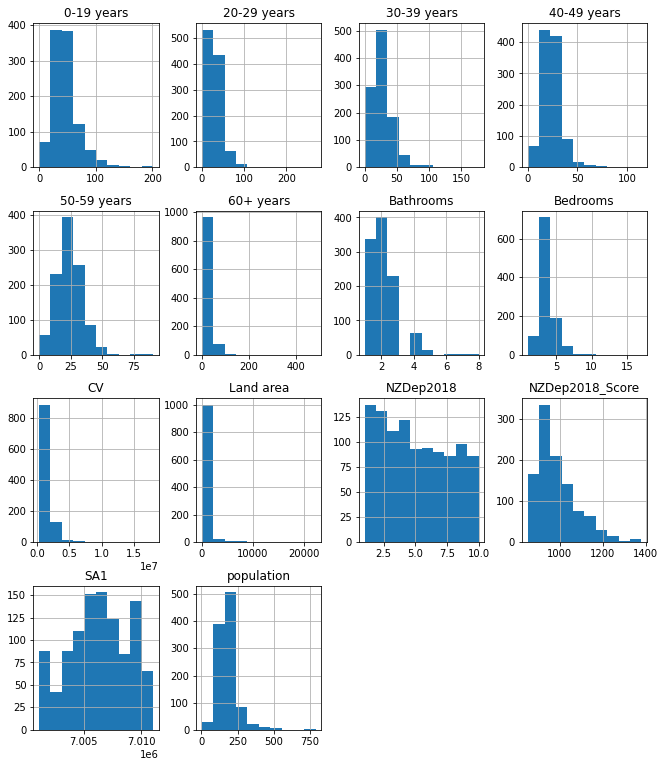

In [24]:
properties.hist(figsize=(11, 13))

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


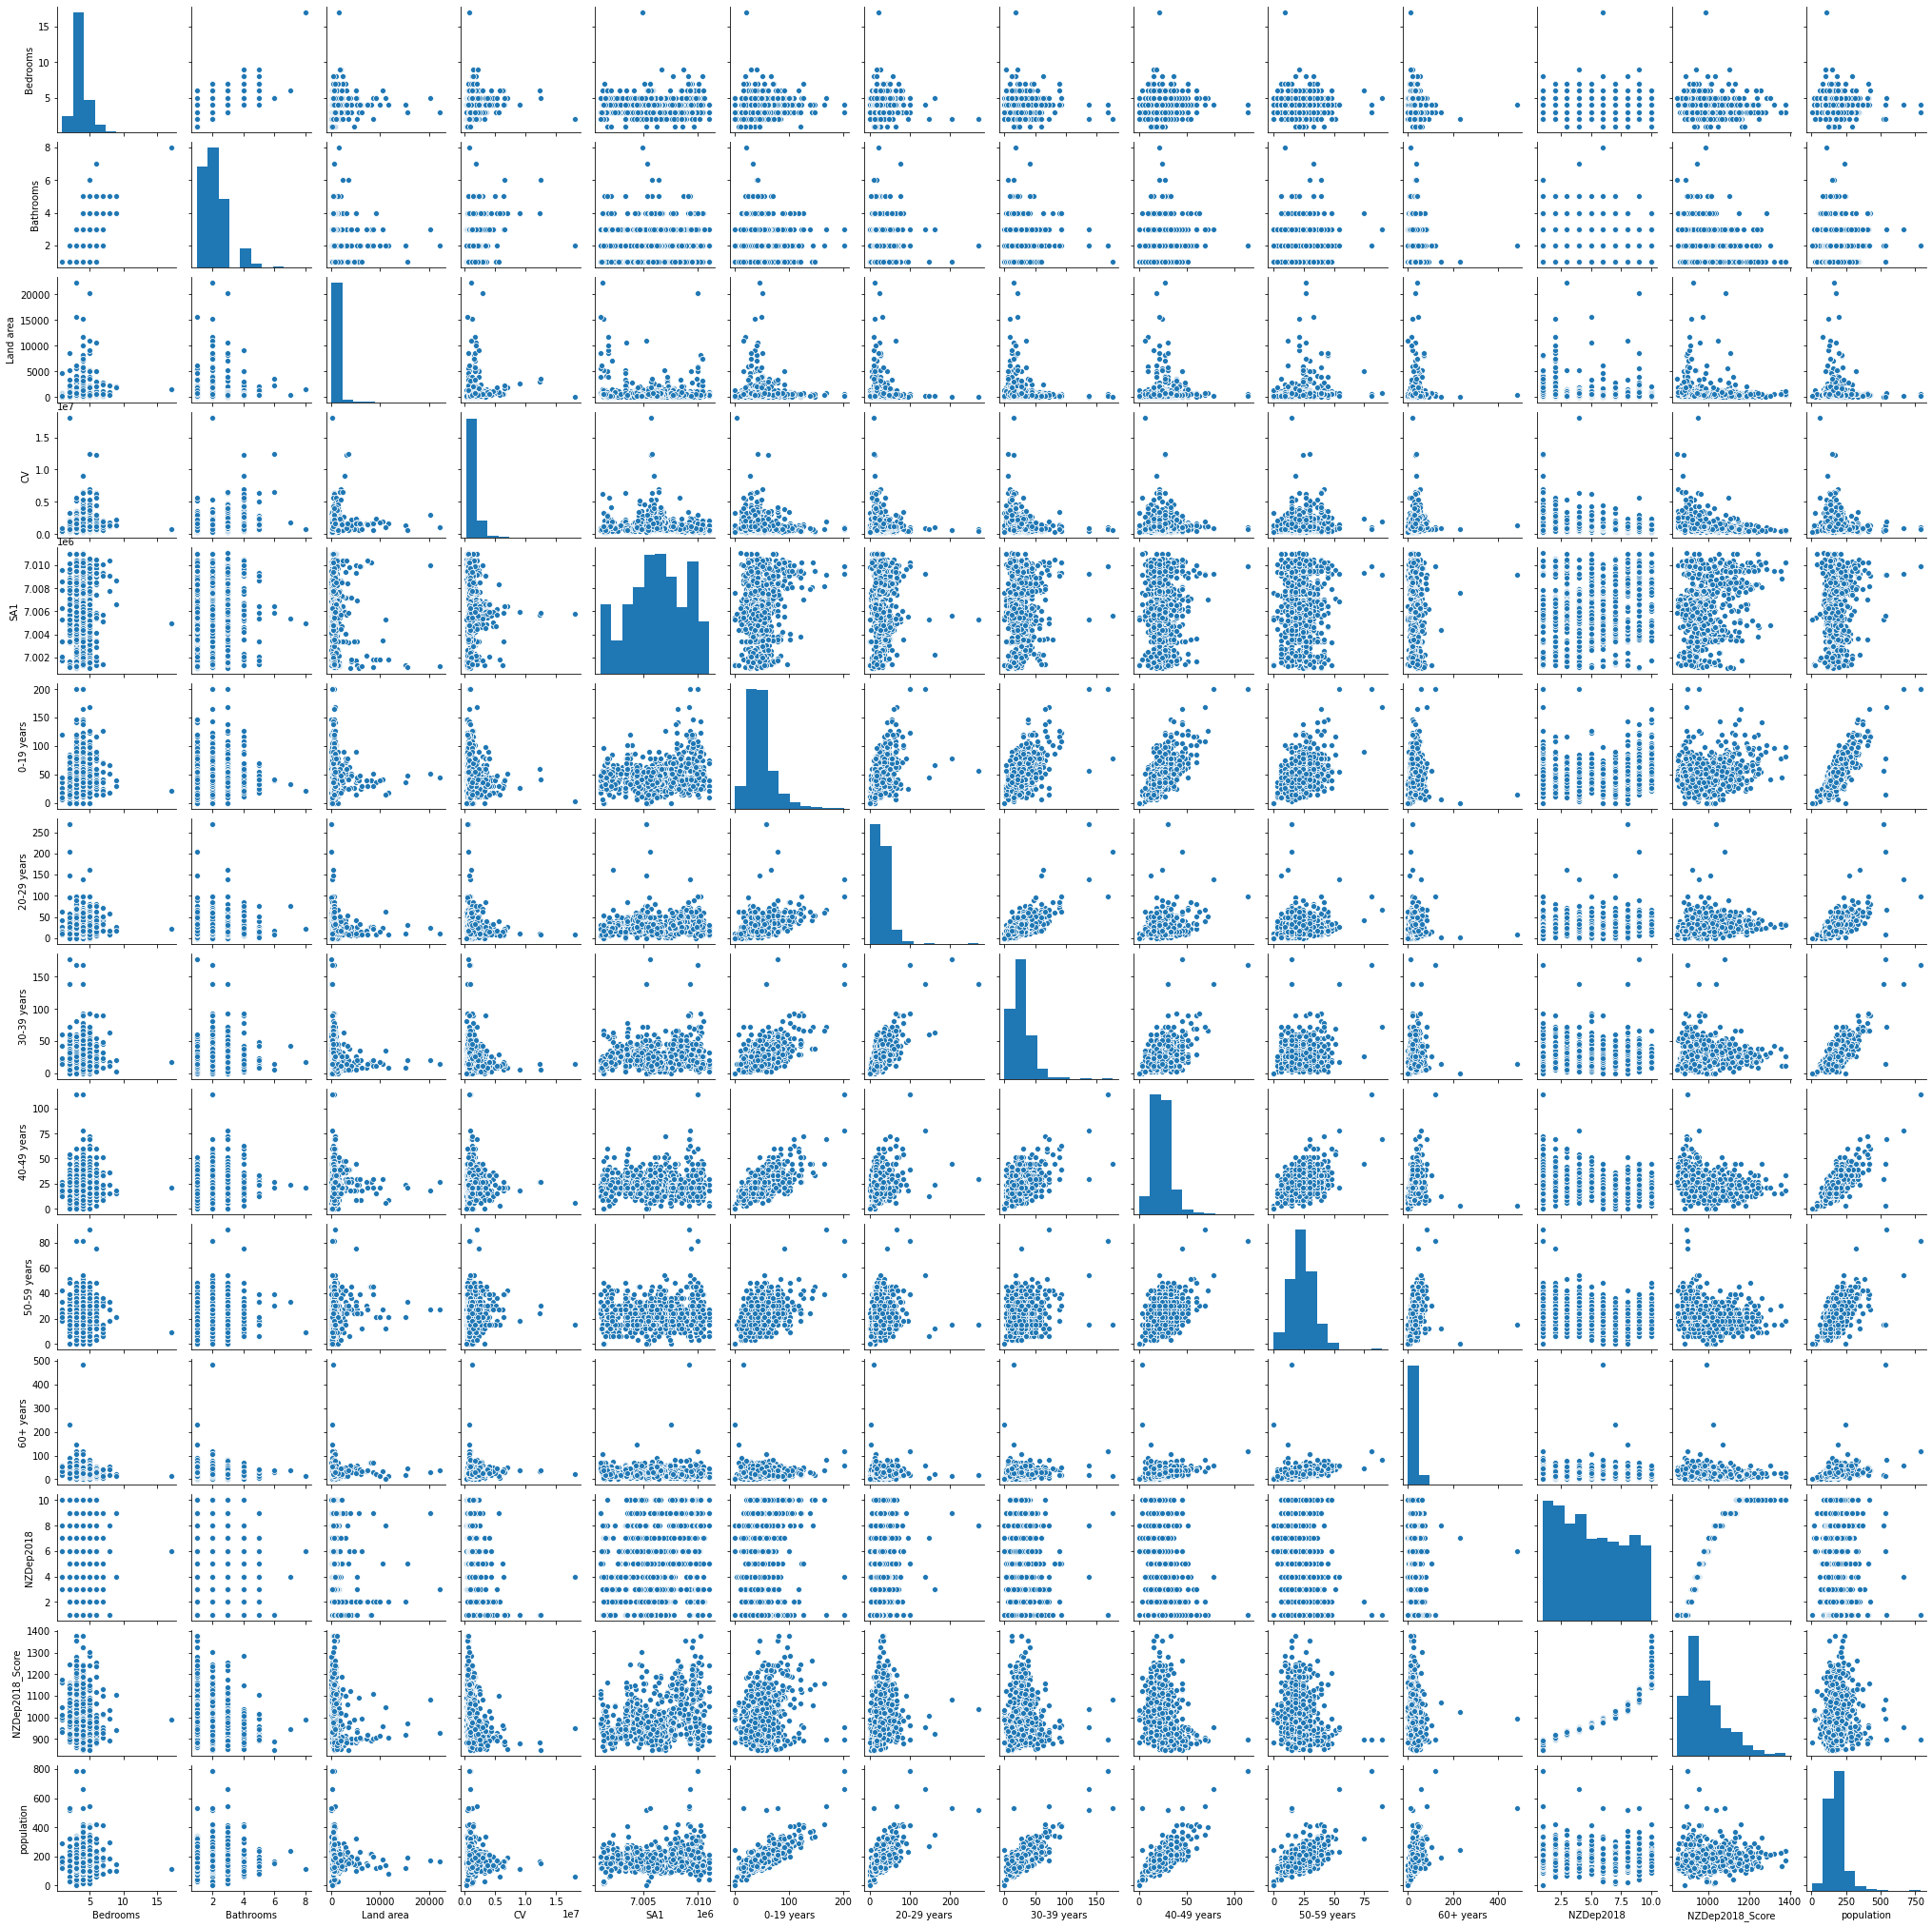

In [25]:
sns.pairplot(properties, size = 2.0)

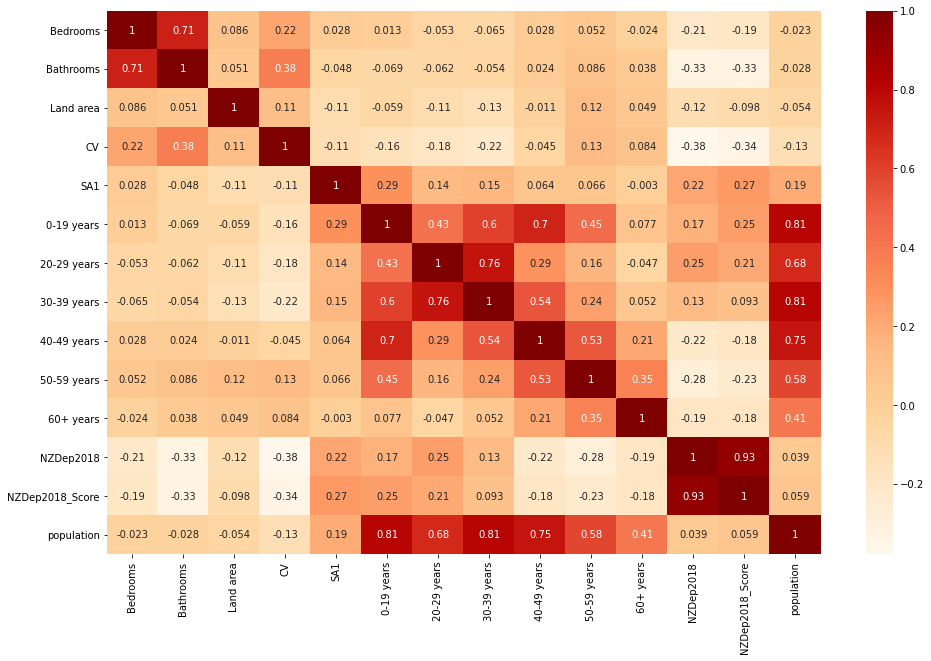

In [27]:
ax, fig = plt.subplots(figsize=(16,10))
correlation_matrix = properties.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="OrRd")
plt.show()

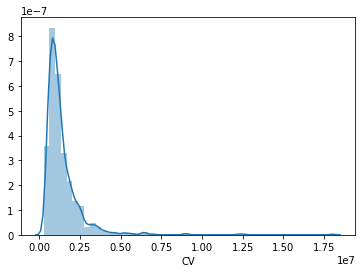

In [26]:
sns.distplot(properties['CV'])

## 3. Machine Learning 

In [28]:
properties = pd.read_csv('Properties_preprocessed.csv')
properties.head()

,Bedrooms,Bathrooms,Land area,CV,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,NZDep2018,NZDep2018_Score,population
0,5,3.0,714.0,960000,7009770,48,27,24,21,24,21,Manurewa,6.0,997.0,174
1,5,3.0,564.0,1250000,7009991,42,18,12,21,15,30,Karaka,1.0,881.0,129
2,6,4.0,626.0,1250000,7009991,42,18,12,21,15,30,Karaka,1.0,881.0,129
3,2,1.0,65.0,740000,7007871,42,6,21,21,12,15,Onehunga,2.0,908.0,120
4,3,1.0,601.0,630000,7008902,93,27,33,30,21,33,Clover Park,9.0,1091.0,231


In [29]:
properties.shape

(1048, 15)

In [85]:
# we remove the answer column from the input data. 
# Suburbs is a string and our model doesn't know how to work with strings so we drop that column as well.
x = properties.drop(['CV', 'Suburbs'], axis=1) 
x.head()

,Bedrooms,Bathrooms,Land area,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,NZDep2018,NZDep2018_Score,population
0,5,3.0,714.0,7009770,48,27,24,21,24,21,6.0,997.0,174
1,5,3.0,564.0,7009991,42,18,12,21,15,30,1.0,881.0,129
2,6,4.0,626.0,7009991,42,18,12,21,15,30,1.0,881.0,129
3,2,1.0,65.0,7007871,42,6,21,21,12,15,2.0,908.0,120
4,3,1.0,601.0,7008902,93,27,33,30,21,33,9.0,1091.0,231


In [86]:
# use log CV to make the linear model fit
y = np.log(properties['CV'])
y.head()

0    13.774689
1    14.038654
2    14.038654
3    13.514405
4    13.353475
Name: CV, dtype: float64

In [113]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

### Linear Regression

In [87]:
model = LinearRegression()
model.fit(train_x, train_y)
model.coef_

array([ 1.40139512e-02,  1.59361005e-01,  1.19228463e-05, -6.22696364e-06,
       -2.34920059e-03,  5.27039665e-04, -7.00574136e-03, -3.31724977e-04,
        5.46001467e-03,  4.56981509e-04, -6.53973202e-02, -1.63067104e-04,
        7.70321369e-04])

Text(0, 0.5, 'predicted_CV')

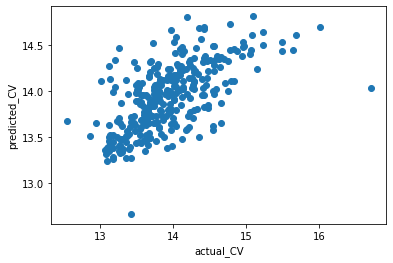

In [88]:
predicted = model.predict(test_x)

# See the difference between the predicted CV and the actual CV.
plt.scatter(test_y, predicted)
plt.xlabel('actual_CV')
plt.ylabel('predicted_CV')

In [89]:
R_squared = model.score(test_x, test_y)
RMSE = np.sqrt(mean_squared_error(test_y, predicted))
print(R_squared)
print(RMSE)

0.39428001115196953
0.43516111693828924


### Random Forest

In [92]:
from sklearn import ensemble
RF = ensemble.RandomForestRegressor()
RF.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Text(0, 0.5, 'predicted_CV')

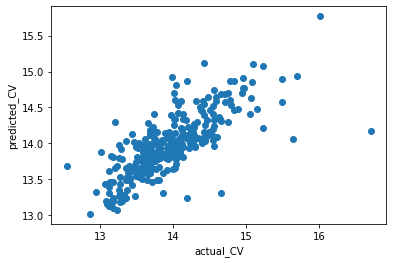

In [95]:
predicted = RF.predict(test_x)
plt.scatter(test_y, predicted)
plt.xlabel('actual_CV')
plt.ylabel('predicted_CV')

In [97]:
R_squared = RF.score(test_x, test_y)
RMSE = np.sqrt(mean_squared_error(test_y, predicted))
print(R_squared)
print(RMSE)

0.585266041138168
0.3600799408732803


### XGBoost

In [109]:
!pip install xgboost
import xgboost as xgb
GB = xgb.XGBRegressor()
GB.fit(train_x, train_y)

[11:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Text(0, 0.5, 'predicted_CV')

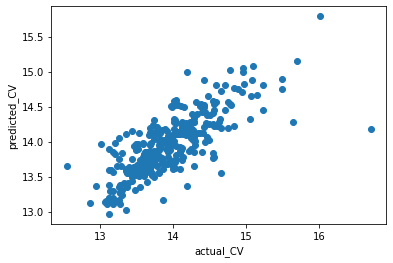

In [111]:
predicted = GB.predict(test_x)
plt.scatter(test_y, predicted)
plt.xlabel('actual_CV')
plt.ylabel('predicted_CV')

In [112]:
R_squared = GB.score(test_x, test_y)
RMSE = np.sqrt(mean_squared_error(test_y, predicted))
print(R_squared)
print(RMSE)

0.6016696401207937
0.35288714187296416
